<a href="https://colab.research.google.com/github/andersonsam/cnn_lstm_era_hindcast/blob/main/sine_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

In [1]:
# Colab can access/save data stored in google drive.  Here is the directory structure in google drive -- set this up before running code

# My Drive/
# |__ Colab Notebooks/
#     |__ cnn_lstm_era/
#         |__ data/
#         |__ models/
#         |__ output/
#         |__ heat_maps/

dir_data = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output' #where to save trained model outputs

dir_models_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/models_north' #where to save trained models
dir_output_north = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/output_north' #where to save trained model outputs


In [2]:
#download required libraries which are not in colab

!pip install geopandas
!pip install netCDF4
!pip install guppy3
!pip install pymannkendall

     |████████████████████████████████| 1.0MB 6.5MB/s 
     |████████████████████████████████| 6.5MB 16.1MB/s 
     |████████████████████████████████| 15.3MB 475kB/s 
     |████████████████████████████████| 4.7MB 5.2MB/s 
     |████████████████████████████████| 317kB 41.2MB/s 
     |████████████████████████████████| 614kB 5.9MB/s 


In [3]:
#import required libraries

%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm#, colors, path
from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition

import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

import pickle
import os
from random import seed
from datetime import datetime, date, timedelta
from netCDF4 import Dataset
from guppy import hpy
from google.colab import drive
import pymannkendall as mk

from shapely.geometry import Point, Polygon
from descartes import PolygonPatch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [4]:
#mount google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#define functions

def gaussian(x):
  y = np.exp(-x**2/2)
  return y

def get_seasonal_inds_from_list(date_list):

  """
  From a list of dates, return the indices of each season.
  """

  m = np.array([d.month for d in date_list])
  inds_DJF = np.squeeze(np.argwhere((m == 12) | (m ==  1) | (m ==  2)))
  inds_MAM = np.squeeze(np.argwhere((m ==  3) | (m ==  4) | (m ==  5)))
  inds_JJA = np.squeeze(np.argwhere((m ==  6) | (m ==  7) | (m ==  8)))
  inds_SON = np.squeeze(np.argwhere((m ==  9) | (m == 10) | (m == 11)))

  return inds_DJF, inds_MAM, inds_JJA, inds_SON

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse

def rmse(y_model, y_obs):

  RMSE = np.sqrt( np.nanmean( (y_model - y_obs)**2 ) )

  return RMSE

def plot_prov_ax(prov, ax):

  """
  plot borders of a province on a given axis

  prov: list of strings of provincial abbreviations; ['AB'], ['BC'], ['AB','BC'], etc; prov = 'all' will plot all provincial/territorial borders
  ax: axis on which to plot the provincial borders

  Examples:

  fig, ax = plt.subplots()
  plot_prov_ax(prov = ['BC', 'AB', 'SK'], ax = ax) #plots British Colubmia, Alberta, and Saskatchewan

  fig, ax = plt.subplots()
  plot_prov_ax(prov = 'all', ax = ax) #plots all provincial/territorial borders
  """

  #load shapefile of provincial boundaries
  provshapes_filename = '/content/drive/My Drive/Colab Notebooks/cnn_lstm_era/data/PROVINCE.SHP'
  provshapes = gpd.read_file(provshapes_filename)

  #create list of all prov/territorial abbreviations
  prov_abbreviations = [
                        'AB',
                        'SK',
                        'MB',
                        'NL',
                        'PE',
                        'NS',
                        'NT',
                        'NU',
                        'ON',
                        'NB',
                        'YT',
                        'BC',
                        'QC'
                      ]

  #if wanting to plot all borders
  if prov == 'all':
    prov = prov_abbreviations

  #loop through each input province/territory and plot borders
  for pv in prov:

    #polygons of this province/territory
    prov_poly = provshapes['geometry'][prov_abbreviations.index(pv)]

    #some jurisdictions have multiple polygones from lakes/islands/etc (e.g. BC)
    if len(np.shape(prov_poly)) == 0: #if only one polygon to plot

      lonBorder,latBorder = prov_poly.exterior.coords.xy 
      ax.plot(lonBorder,latBorder,'k')

    else: #if multiply polygons in shape to plot

      for ind in range(len(prov_poly)): 
        lonBorder_segment,latBorder_segment = prov_poly[ind].exterior.coords.xy 
        ax.plot(lonBorder_segment,latBorder_segment,'k')

def plot_dendrogram(model, **kwargs):

  """
  model: Agglomerative clustering model

  Creates linkage matrix and then plots the dendrogram
  Returns dendrogram

  Code from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
  """

  # create the counts of samples under each node
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  d = dendrogram(linkage_matrix, **kwargs)

  return d

# Onset range sensitivity

In [124]:
#"Edmonton-like"
T = 14
T0 = 3
sigma_s = 11
sigma_w = 9

# #"Lethbridge-like"
# T = 12
# T0 = 6
# sigma_s = 16
# sigma_w = 11

#"Lloydminster-like"
T = 15
T0 = 2.5
sigma_s = 10
sigma_w = 8

#Example
T = 15
T0 = 2.5
sigma_s = 6
sigma_w = 12

omega = 2*np.pi / 365
phi = 0.3

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

Tmean = T0 - T*np.sin(omega*t - phi)
Tp = T0 + A - B*np.sin(omega*t - phi)
Tm = T0 + C - D*np.sin(omega*t - phi)

tmeanf = (1/omega) * (phi + np.arcsin(T0/T))
tmeanm = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

tpf = (1/omega) * (phi + np.arcsin((T0+A)/B))
tpm = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

tmf = (1/omega) * (phi + np.arcsin((T0+C)/D))
tmm = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

Dsnow = tpm - tpf

dtmeanf_dT0 =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
dtmeanm_dT0 = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

dtpf_dT0 =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
dtpm_dT0 = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

dtmf_dT0 =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
dtmm_dT0 = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

dDsnow_dT0 = dtpm_dT0 - dtpf_dT0

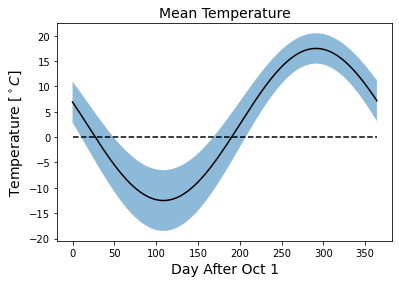

In [126]:
saveIt = 0

fs = 14

fig, ax = plt.subplots()

ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot(t, Tmean, 'k')

plt.plot(t, np.zeros(len(t)), 'k--')

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)
# ax.set_ylim((-14,19))

if saveIt:
  plt.savefig('regular_with_shading.png', bbox_inches = 'tight', dpi = 300)

plt.show()

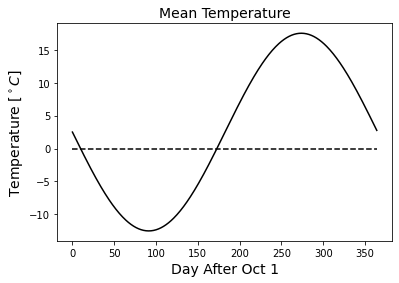

In [37]:
saveIt = 0

fs = 14

fig, ax = plt.subplots()

# ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot(t, Tmean, 'k')
ax.plot(t, np.zeros(len(t)), 'k--')

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)
ax.set_ylim((-14,19))

if saveIt:
  plt.savefig('regular_sine2.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [42]:
#"Lloydminster-like"
T = 15
T0 = 2.5
sigma_s = 10
sigma_w = 8

omega = 2*np.pi / 365
phi = 0

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

Tmean1 = T0 - T*np.sin(omega*t - phi)

#"Lloydminster-like"
T = 15
T0 = 7.5
sigma_s = 10
sigma_w = 8

omega = 2*np.pi / 365
phi = 0

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

Tmean2 = T0 - T*np.sin(omega*t - phi)


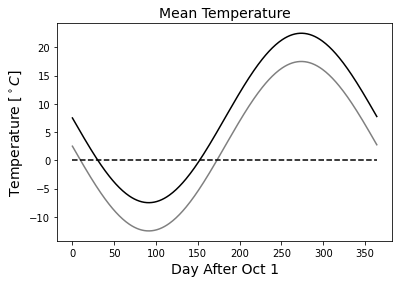

In [45]:
saveIt = 0

fs = 14

fig, ax = plt.subplots()

# ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot(t, Tmean1, 'gray')
ax.plot(t, Tmean2, 'k')
ax.plot(t, np.zeros(len(t)), 'k--')

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)
# ax.set_ylim((-14,19))

if saveIt:
  plt.savefig('regular_sine_shift.png', bbox_inches = 'tight', dpi = 300)

plt.show()

In [146]:
#multiple T0s

T0s = np.arange(-15,15,0.1)
Dsnow = np.zeros(len(T0s))
dDsnow_dT0 = np.zeros(len(T0s))
dDsnowmean_dT0 = np.zeros(len(T0s))
dDsnowmean_dTs = np.zeros(len(T0s))
dDsnowmean_dTw = np.zeros(len(T0s))

for kk, T0 in enumerate(T0s):

  #"Edmonton-like"
  T = 14
  sigma_s = 11
  sigma_w = 9

  # #"Lethbridge-like"
  # T = 12
  # T0 = 6
  # sigma_s = 16
  # sigma_w = 11

  #"Lloydminster-like"
  T = 15
  # T0 = 2.5
  sigma_s = 10
  sigma_w = 8

  Tw = T0 - T
  Ts = T0 + T

  omega = 2*np.pi / 365
  phi = 0

  A =  0.25 * ( sigma_s + sigma_w )
  B =  0.25 * ( sigma_s - sigma_w ) + T
  C = -0.25 * ( sigma_s + sigma_w )
  D =  0.25 * (-sigma_s + sigma_w ) + T

  t = np.arange(365)

  Tmean = T0 - T*np.sin(omega*t - phi)
  Tp = T0 + A - B*np.sin(omega*t - phi)
  Tm = T0 + C - D*np.sin(omega*t - phi)

  tmeanf = (1/omega) * (phi + np.arcsin(T0/T))
  tmeanm = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

  tpf = (1/omega) * (phi + np.arcsin((T0+A)/B))
  tpm = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

  tmf = (1/omega) * (phi + np.arcsin((T0+C)/D))
  tmm = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

  Dsnow[kk] = tpm - tpf

  dtmeanf_dT0 =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
  dtmeanm_dT0 = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

  dtmeanf_dTs =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )
  dtmeanm_dTs = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )

  dtmeanf_dTw =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )
  dtmeanm_dTw = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )

  dtpf_dT0 =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
  dtpm_dT0 = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

  dtmf_dT0 =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
  dtmm_dT0 = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

  dDsnow_dT0[kk] = dtpm_dT0 - dtpf_dT0
  dDsnowmean_dT0[kk] = dtmeanm_dT0 - dtmeanf_dT0
  dDsnowmean_dTs[kk] = dtmeanm_dTs - dtmeanf_dTs
  dDsnowmean_dTw[kk] = dtmeanm_dTw - dtmeanf_dTw

  # dDsnowmean_dT0[kk] = -(2 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
  # dDsnowmean_dTs[kk] =  (2 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( Tw / ((Ts-Tw)**2) )
  # dDsnowmean_dTw[kk] = -(2 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( Ts / ((Ts-Tw)**2) )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/

In [147]:
Ts, Tw, T, T0, Ts - Tw, (Ts + Tw)/2

(29.899999999999892,
 -0.100000000000108,
 15,
 14.899999999999892,
 30.0,
 14.899999999999892)

Text(0.5, 0, 'T0')

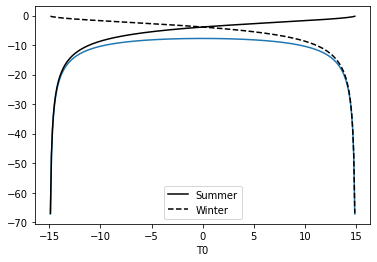

In [148]:
plt.plot(T0s,dDsnowmean_dT0)
plt.plot(T0s,dDsnowmean_dTs, 'k', label = 'Summer')
plt.plot(T0s,dDsnowmean_dTw, 'k--', label = 'Winter')
plt.legend()
plt.xlabel('T0')

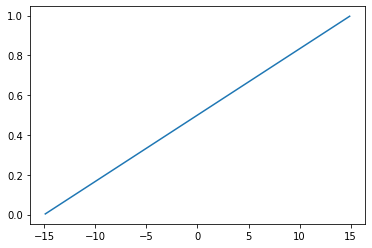

In [149]:
frac_winter = dDsnowmean_dTw / dDsnowmean_dT0

plt.plot(T0s, frac_winter)

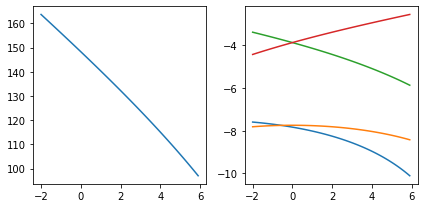

In [49]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (6,3))
ax[0].plot(T0s, Dsnow)
ax[1].plot(T0s, dDsnow_dT0)
ax[1].plot(T0s, dDsnowmean_dT0)
ax[1].plot(T0s, dDsnowmean_dTw)
ax[1].plot(T0s, dDsnowmean_dTs)

plt.tight_layout()

In [50]:
#load daily temperature data
# pickle_in = open(dir_data + '/' + 'tempDict_ERA5_1979_2020_075grid_AB_BC.pickle','rb')
pickle_in = open(dir_data + '/' + 'maxTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']
date_str = [str(int(eraDays[kk])) + '-' +  str(int(eraMonths[kk])) + '-' + str(int(eraYears[kk])) for kk in range(len(eraYears))]
eraDate = [datetime.strptime(d_str, '%d-%m-%Y') for d_str in date_str]
extentERA = [np.min(eraLon),np.max(eraLon),np.min(eraLat),np.max(eraLat)]

Tmax = np.asarray(tempDict['Tmax'])

pickle_in = open(dir_data + '/' + 'minTDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
tempDict = pickle.load(pickle_in)

Tmin = np.asarray(tempDict['Tmin'])

Tmean = np.mean([Tmax,Tmin], axis = 0)

#load daily precipitation data
pickle_in = open(dir_data + '/' + 'precDict_ERA5_1979_2018_025grid_AB_BC.pickle','rb')
precDict = pickle.load(pickle_in)
P = np.asarray(precDict['P'])

Nlat = np.shape(Tmax)[1]
Nlon = np.shape(Tmax)[2]
Npx = Nlat*Nlon #number of pixels

Tmax_px = Tmax.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmin_px = Tmin.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
Tmean_px = Tmean.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px = P.reshape(-1,Nlat*Nlon) #each column is a pixel's time series of temperature
P_px_new = np.zeros(np.shape(Tmin_px))
P_px_new[:-1,:] = np.copy(P_px)
P_px = P_px_new

delta = timedelta(days = 364)
year_start = 1979
year_fin = 2020
year_fin = 2018

Tmax_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1)))) #days in year  x  pixel  x  year
Tmin_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
Tmean_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))
P_seasonal_yearly = np.zeros((365, Npx, len(range(year_start,year_fin+1))))

kk = 0

for nn, year in enumerate(range(year_start, year_fin+1)):

  start_date = datetime(year, 1, 1)
  fin_date = start_date + delta

  start_ind = eraDate.index(start_date)
  fin_ind = eraDate.index(fin_date)

  Tmax_seasonal_yearly[:,:,nn] = Tmax_px[start_ind:fin_ind+1,:]
  Tmin_seasonal_yearly[:,:,nn] = Tmin_px[start_ind:fin_ind+1,:]
  Tmean_seasonal_yearly[:,:,nn] = Tmean_px[start_ind:fin_ind+1,:]
  P_seasonal_yearly[:,:,nn] = P_px[start_ind:fin_ind+1,:]

Tmax_seasonal = np.mean(Tmax_seasonal_yearly, axis = -1)
Tmin_seasonal = np.mean(Tmin_seasonal_yearly, axis = -1)
Tmean_seasonal = np.mean(Tmean_seasonal_yearly, axis = -1)
P_seasonal = np.mean(P_seasonal_yearly, axis = -1)

In [217]:
deltaTw = np.zeros(Npx)
deltaTs = np.zeros(Npx)
for pixel in range(Npx):

  yrs = np.arange(1998,2018)
  Nyrs = len(yrs)

  Twinter = np.mean(Tmean_seasonal_yearly[DJF_inds,pixel,-Nyrs:], axis = 0)
  Tsummer = np.mean(Tmean_seasonal_yearly[JJA_inds,pixel,-Nyrs:], axis = 0)

  X = yrs.reshape(-1,1)
  y = Twinter.reshape(-1,1)
  lm = LinearRegression().fit(X = X, y = y)
  slopeTw = lm.coef_
  deltaTw[pixel] = slopeTw*(year_fin - year_start)

  y = Tsummer.reshape(-1,1)
  lm = LinearRegression().fit(X = X, y = y)
  slopeTs = lm.coef_
  deltaTs[pixel] = slopeTs*(year_fin - year_start)

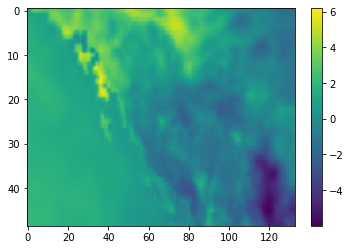

In [219]:
plt.imshow(deltaTw.reshape(Nlat,Nlon), aspect = 'auto')#, vmin = 0, vmax = 7)
plt.colorbar()

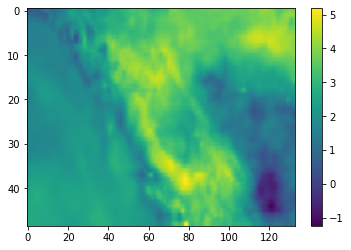

In [221]:
plt.imshow(deltaTs.reshape(Nlat,Nlon), aspect = 'auto')#, vmin = 0, vmax = 7)
plt.colorbar()

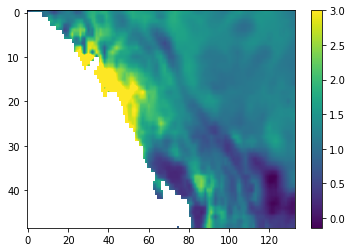

In [210]:
dDelta_w = fw * deltaTw
dDelta_s = (1 - fw) * deltaTs

plt.imshow(dDelta_w.reshape(Nlat,Nlon), aspect = 'auto', vmax = 3)#, vmin = 0, vmax = 7)
plt.colorbar()

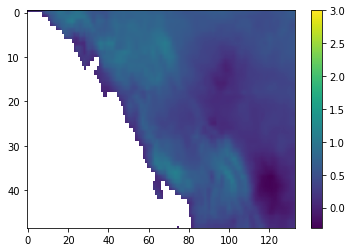

In [211]:
plt.imshow(dDelta_s.reshape(Nlat,Nlon), aspect = 'auto', vmax = 3)#, vmin = 0, vmax = 7)
plt.colorbar()

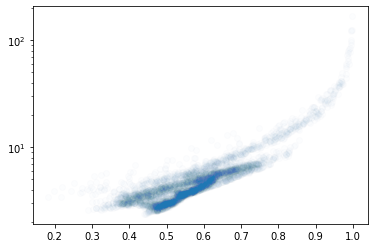

In [216]:
plt.scatter(fw, -dDsnowmean_dTw_px,alpha = 0.01)
plt.yscale('log')

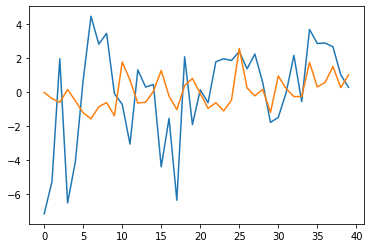

In [184]:
plt.plot(Twinter - np.mean(Twinter))
plt.plot(Tsummer - np.mean(Tsummer))

In [51]:
sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[:30,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[180:210,px,:]) for px in range(Npx)])

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
# phi = 0

pixel = 4090

t = np.arange(365)

phi_fit = omega*t - np.arcsin((T0_px[pixel] - (Tmean_seasonal[:,pixel]-273.15))/T_px[pixel])
phi_px[pixel] = np.mean(phi_fit)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in arcsin


In [155]:
DJF_inds = np.hstack([np.arange(0,59), np.arange(334,365)])
JJA_inds = np.arange(151,243)

# sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[:30,px,:]) for px in range(Npx)])
# sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[180:210,px,:]) for px in range(Npx)])
sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtmeanf_dTs_px = np.zeros(Npx)
dtmeanm_dTs_px = np.zeros(Npx)
dtmeanf_dTw_px = np.zeros(Npx)
dtmeanm_dTw_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)
dDsnowmean_dTs_px = np.zeros(Npx)
dDsnowmean_dTw_px = np.zeros(Npx)
fw = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)
# phi = 0

# kk = 0
for kk in range(Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

  T0 = T0_px[kk]
  T = T_px[kk]
  sigma_s = 1*sigma_s_px[kk]
  sigma_w = 1*sigma_w_px[kk]
  Tw = T0 - T
  Ts = T0 + T

  # phi = np.nanmean( omega*t - np.arcsin((T0 - (Tmean_seasonal[:,kk]-273.15))/T) )
  # # phi = np.nanmean( omega*t - np.arcsin((T0 - (Tmean_seasonal[:,kk]-273.15))/T) + np.pi/4)
  # # phi = -np.pi/2
  # phi_px[kk] = phi

  N = 100
  err = np.zeros(N)
  phi_tests = np.linspace(0,2*np.pi,N)
  for jj, phi_test in enumerate(phi_tests):
    tmean = T0 - T*np.sin(omega*t - phi_test)
    err[jj] = np.mean((Tmean_seasonal[:,kk] - tmean)**2)

  phi = phi_tests[np.argmin(err)]
  phi_px[kk] = phi

  A =  0.25 * ( sigma_s + sigma_w )
  B =  0.25 * ( sigma_s - sigma_w ) + T
  C = -0.25 * ( sigma_s + sigma_w )
  D =  0.25 * (-sigma_s + sigma_w ) + T

  Tmean = T0 - T*np.sin(omega*t - phi)
  Tp = T0 + A - B*np.sin(omega*t - phi)
  Tm = T0 + C - D*np.sin(omega*t - phi)

  tmeanf[kk] = (1/omega) * (phi + np.arcsin(T0/T))
  tmeanm[kk] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

  tpf[kk] = (1/omega) * (phi + np.arcsin((T0+A)/B))
  tpm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

  tmf[kk] = (1/omega) * (phi + np.arcsin((T0+C)/D))
  tmm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

  if (not np.isnan(tpf[kk])) and (not np.isnan(tmeanf[kk])):

    if tmeanf[kk] > 0 and tpf[kk] > 0:
      P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk])) : int(np.round(tpf[kk])), kk])
      P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      P_transition[kk] = P1 + P2
      P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

    elif tmeanf[kk] < 0 and tpf[kk] > 0:
      P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk])), kk])
      P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      P_transition[kk] = P1 + P2
      P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

    elif tmeanf[kk] < 0 and tpf[kk] < 0:
      # print(kk)
      P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365 : int(np.round(tpf[kk]))+365, kk])
      P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
      P_transition[kk] = P1 + P2
      P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk])), kk])

  Dsnow[kk] = tpm[kk] - tpf[kk]

  dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
  dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

  dtmeanf_dTs_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )
  dtmeanm_dTs_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( -2*Tw / ((Ts-Tw)**2) )

  dtmeanf_dTw_px[kk] =  (1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )
  dtmeanm_dTw_px[kk] = -(1 / (omega)) * np.sqrt(1 - (T0/T)**2)**(-1) * ( 2*Ts / ((Ts-Tw)**2) )

  dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
  dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

  dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
  dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

  dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
  dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]
  dDsnowmean_dTs_px[kk] = dtmeanm_dTs_px[kk] - dtmeanf_dTs_px[kk]
  dDsnowmean_dTw_px[kk] = dtmeanm_dTw_px[kk] - dtmeanf_dTw_px[kk]
  fw[kk] = dDsnowmean_dTw_px[kk] / dDsnowmean_dT0_px[kk]

  # kk+=1

P_ratio = P_transition / (P_transition + P_persist)
sigma_ratio = sigma_w_px / sigma_s_px
mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: 

In [ ]:
#This one: creates multiple curves, colours by probability

DJF_inds = np.hstack([np.arange(0,59), np.arange(334,365)])
JJA_inds = np.arange(151,243)

sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

dfrac = 0.1
sigma_fracs = np.arange(dfrac, 3+dfrac, dfrac)
Nfrac = len(sigma_fracs)

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros((Npx,Nfrac))
tmeanm = np.zeros((Npx,Nfrac))
tpf = np.zeros((Npx,Nfrac))
tpm = np.zeros((Npx,Nfrac))
tmf = np.zeros((Npx,Nfrac))
tmm = np.zeros((Npx,Nfrac))
Dsnow = np.zeros((Npx,Nfrac))

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)
# phi = 0

Tmean = np.zeros((Nfrac, 365))
Tp = np.zeros((Nfrac, 365))
Tm = np.zeros((Nfrac, 365))

for jj, sigma_frac in enumerate(sigma_fracs):

  for kk in range(1): #Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

    T0 = T0_px[kk]
    T = T_px[kk]
    sigma_s = sigma_frac*sigma_s_px[kk]
    sigma_w = sigma_frac*sigma_w_px[kk]

    # N = 100
    # err = np.zeros(N)
    # phi_tests = np.linspace(0,2*np.pi,N)
    # for jj, phi_test in enumerate(phi_tests):
    #   tmean = T0 - T*np.sin(omega*t - phi_test)
    #   err[jj] = np.mean((Tmean_seasonal[:,kk] - tmean)**2)

    # phi = phi_tests[np.argmin(err)]
    phi = np.pi / 2
    phi_px[kk] = np.pi  #0 #phi

    A =  0.25 * ( sigma_s + sigma_w )
    B =  0.25 * ( sigma_s - sigma_w ) + T
    C = -0.25 * ( sigma_s + sigma_w )
    D =  0.25 * (-sigma_s + sigma_w ) + T

    Tmean[jj,:] = T0 - T*np.sin(omega*t - phi)
    Tp[jj,:] = T0 + A - B*np.sin(omega*t - phi)
    Tm[jj,:] = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[kk,jj] = (1/omega) * (phi + np.arcsin(T0/T))
    tmeanm[kk,jj] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

    tpf[kk,jj] = (1/omega) * (phi + np.arcsin((T0+A)/B))
    tpm[kk,jj] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    tmf[kk,jj] = (1/omega) * (phi + np.arcsin((T0+C)/D))
    tmm[kk,jj] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    if (not np.isnan(tpf[kk,jj])) and (not np.isnan(tmeanf[kk,jj])):

      if tmeanf[kk,jj] > 0 and tpf[kk,jj] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk,jj])) : int(np.round(tpf[kk,jj])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk,jj])) : int(np.round(tmeanm[kk,jj])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk,jj])) : int(np.round(tpm[kk,jj])), kk])

      elif tmeanf[kk,jj] < 0 and tpf[kk,jj] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk,jj]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk,jj])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk,jj])) : int(np.round(tmeanm[kk,jj])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk,jj])) : int(np.round(tpm[kk,jj])), kk])

      elif tmeanf[kk,jj] < 0 and tpf[kk,jj] < 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk,jj]))+365 : int(np.round(tpf[kk,jj]))+365, kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk,jj])) : int(np.round(tmeanm[kk,jj])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk,jj]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk,jj])), kk])

    Dsnow[kk,jj] = tpm[kk,jj] - tpf[kk,jj]

    dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
    dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

    dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]

P_ratio = P_transition / (P_transition + P_persist)
sigma_ratio = sigma_w_px / sigma_s_px
mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))


#plot figure
cmap = 'Blues'
cmap = cm.get_cmap(cmap)
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 1)

fig, ax = plt.subplots()

for kk, sigma_frac in enumerate(sigma_fracs):
  color = cmap(norm(gaussian(sigma_frac)))
  ax.plot(Tp[kk,:], color = color)
  ax.plot(Tm[kk,:], color = color)

ax.plot(Tmean[0,:], color = 'k', linewidth = 3)
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in sqrt


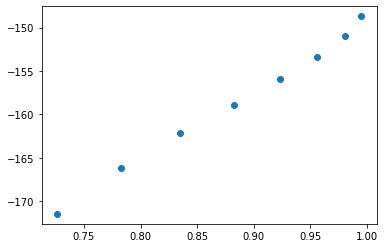

In [ ]:
plt.scatter(gaussian(sigma_fracs), tpm[0,:] - 365)

In [175]:
np.shape(Tmean_seasonal_yearly)

(365, 6517, 40)

In [ ]:
#calculate z-score (and sensitivity to temperature perturbations) for each day in 'freeze' period (where Tmean < 0)

DJF_inds = np.hstack([np.arange(0,59), np.arange(334,365)])
JJA_inds = np.arange(151,243)

sigma_w_px = np.array([np.std(Tmean_seasonal_yearly[DJF_inds,px,:]) for px in range(Npx)])
sigma_s_px = np.array([np.std(Tmean_seasonal_yearly[JJA_inds,px,:]) for px in range(Npx)])

T0_perturbs = np.array([-2,0,2])
Nperturbs = len(T0_perturbs)

T0_px = np.mean(Tmean_seasonal, axis = 0) - 273
T_px = (np.max(Tmean_seasonal, axis = 0) - np.min(Tmean_seasonal, axis = 0)) / 2
phi_px = np.zeros(Npx)

tmeanf = np.zeros(Npx)
tmeanm = np.zeros(Npx)
tpf = np.zeros(Npx)
tpm = np.zeros(Npx)
tmf = np.zeros(Npx)
tmm = np.zeros(Npx)
Dsnow = np.zeros(Npx)

dtmeanf_dT0_px = np.zeros(Npx)
dtmeanm_dT0_px = np.zeros(Npx)
dtpf_dT0_px = np.zeros(Npx)
dtpm_dT0_px = np.zeros(Npx)
dtmf_dT0_px = np.zeros(Npx)
dtmm_dT0_px = np.zeros(Npx)
dDsnow_dT0_px = np.zeros(Npx)
dDsnowmean_dT0_px = np.zeros(Npx)

P_transition = np.nan*np.ones(Npx)
P_persist = np.nan*np.ones(Npx)
zmedian = np.nan*np.ones((Npx, Nperturbs))
dzmedian_dT0_px = np.nan*np.ones(Npx)

omega = 2*np.pi / 365
t = np.arange(365)

for jj, T0_perturb in enumerate(T0_perturbs):

  for kk in range(Npx): #T0, T, sigma_s, sigma_w in zip(T0_px, T_px, sigma_s_px, sigma_w_px):

    T0 = T0_px[kk] + T0_perturb
    T = T_px[kk]
    sigma_s = 1*sigma_s_px[kk]
    sigma_w = 1*sigma_w_px[kk]

    # N = 100
    # err = np.zeros(N)
    # phi_tests = np.linspace(0,2*np.pi,N)
    # for jj, phi_test in enumerate(phi_tests):
    #   tmean = T0 - T*np.sin(omega*t - phi_test)
    #   err[jj] = np.mean((Tmean_seasonal[:,kk] - tmean)**2)

    phi = np.pi / 2 #phi_tests[np.argmin(err)]
    phi_px[kk] = phi

    A =  0.25 * ( sigma_s + sigma_w )
    B =  0.25 * ( sigma_s - sigma_w ) + T
    C = -0.25 * ( sigma_s + sigma_w )
    D =  0.25 * (-sigma_s + sigma_w ) + T

    Tmean = T0 - T*np.sin(omega*t - phi)
    Tp = T0 + A - B*np.sin(omega*t - phi)
    Tm = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[kk] = (1/omega) * (phi + np.arcsin(T0/T))
    tmeanm[kk] = (1/omega) * (np.pi + phi - np.arcsin(T0/T))

    tpf[kk] = (1/omega) * (phi + np.arcsin((T0+A)/B))
    tpm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    tmf[kk] = (1/omega) * (phi + np.arcsin((T0+C)/D))
    tmm[kk] = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    if (not np.isnan(tpf[kk])) and (not np.isnan(tmeanf[kk])):

      t1 = int(np.round(tmeanf[kk]))
      t2 = int(np.round(tmeanm[kk]))
      zs = np.abs(Tmean[t1:t2]) / (Tp[t1:t2] - Tmean[t1:t2])
      zmedian[kk,jj] = np.median(zs)

      if tmeanf[kk] > 0 and tpf[kk] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk])) : int(np.round(tpf[kk])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      elif tmeanf[kk] < 0 and tpf[kk] > 0:
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365: , kk]) + np.sum(P_seasonal[ : int(np.round(tpf[kk])), kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk])) : int(np.round(tpm[kk])), kk])

      elif tmeanf[kk] < 0 and tpf[kk] < 0:
        # print(kk)
        P1 = np.sum(P_seasonal[int(np.round(tmeanf[kk]))+365 : int(np.round(tpf[kk]))+365, kk])
        P2 = np.sum(P_seasonal[int(np.round(tpm[kk])) : int(np.round(tmeanm[kk])), kk])
        P_transition[kk] = P1 + P2
        P_persist[kk] = np.sum(P_seasonal[int(np.round(tpf[kk]))+365: , kk]) + np.sum(P_seasonal[: int(np.round(tpm[kk])), kk])

    Dsnow[kk] = tpm[kk] - tpf[kk]

    dtmeanf_dT0_px[kk] =  (1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)
    dtmeanm_dT0_px[kk] = -(1 / (omega*T)) * np.sqrt(1 - (T0/T)**2)**(-1)

    dtpf_dT0_px[kk] =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    dtpm_dT0_px[kk] = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    dtmf_dT0_px[kk] =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    dtmm_dT0_px[kk] = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    dDsnow_dT0_px[kk] = dtpm_dT0_px[kk] - dtpf_dT0_px[kk]
    dDsnowmean_dT0_px[kk] = dtmeanm_dT0_px[kk] - dtmeanf_dT0_px[kk]

    # kk+=1

P_ratio = P_transition / (P_transition + P_persist)
sigma_ratio = sigma_w_px / sigma_s_px
mask = np.squeeze(np.argwhere(np.isnan(dDsnow_dT0_px)))

for kk in range(Npx):
  X = T0_perturbs.reshape(-1,1)
  y = zmedian[kk,:].reshape(-1,1)

  if sum(np.isfinite(y))[0] == Nperturbs: #if all values are true

    lm = LinearRegression().fit(X,y)
    
    dzmedian_dT0_px[kk] = lm.coef_[0][0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in arcsin
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: Run

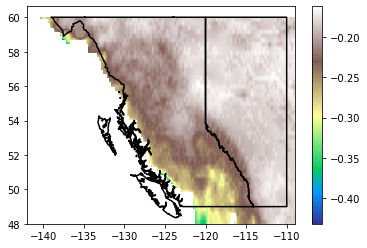

In [ ]:
var = zmedian[:,1]
var = dzmedian_dT0_px

fig, ax = plt.subplots()
im=ax.imshow(var.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, cmap = 'terrain_r')#vmin = -0.3)
plot_prov_ax(['BC','AB'],ax)
plt.colorbar(im)

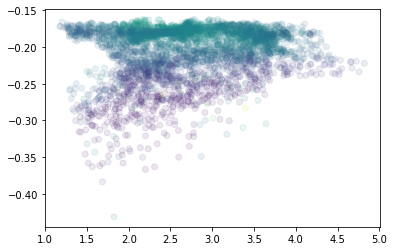

In [ ]:
plt.scatter(zmedian[:,1], dzmedian_dT0_px, c = sigma_ratio, alpha = 0.1)

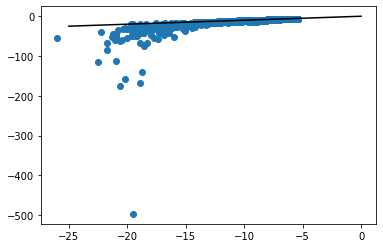

In [ ]:
plt.scatter(dDsnowmean_dT0_px, dDsnow_dT0_px)
plt.plot([-25,0],[-25,0], 'k')
# plt.ylim(bottom = -100)

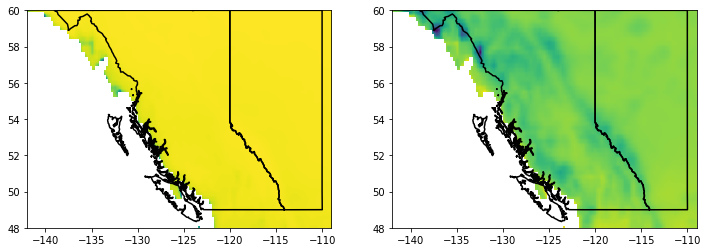

In [91]:
vars = [phi_px, Dsnow, P_ratio, sigma_ratio, tpm]#, zmedian[:,1], dzmedian_dT0_px, dDsnow_dT0_px]
vmin = [np.nanmin(var) for var in vars]
# vmin[-2] = -0.3
# vmin[-1] = -20

nrows = 1
ncols = int(np.ceil(len(vars)/nrows))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

kk = 0
for var, ax in zip(vars, axes.flatten()):
  var_mask = np.copy(var)
  var_mask[mask] = np.nan
  im = ax.imshow(var_mask.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = vmin[kk])
  plot_prov_ax(['BC','AB'], ax)
  ax.set_ylim((np.min(eraLat), np.max(eraLat)))
  kk+=1

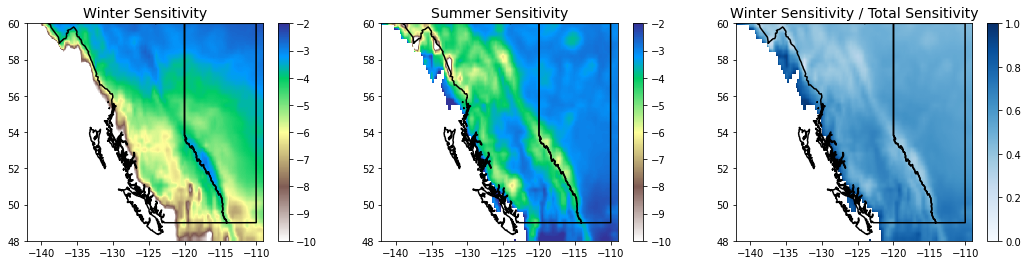

In [222]:
saveIt = 0

vars = [dDsnowmean_dTw_px, dDsnowmean_dTs_px, fw]
vmin = [np.nanmin(var) for var in vars]
titles = ['Winter Sensitivity', 'Summer Sensitivity', 'Winter Sensitivity / Total Sensitivity']
cmaps = ['terrain_r', 'terrain_r', 'Blues']
vmin[0] = -15
vmin[1] = -5
vmin = [-10, -10, 0]
vmax = [-2, -2, 1]
# vmin[-2] = -0.3
# vmin[-1] = -20

nrows = 1
ncols = int(np.ceil(len(vars)/nrows))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6*ncols, 4*nrows))

kk = 0
for var, ax in zip(vars, axes.flatten()):
  var_mask = np.copy(var)
  # var_mask[mask] = np.nan
  im = ax.imshow(var_mask.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, cmap = cmaps[kk], vmax = vmax[kk], vmin = vmin[kk])
  plot_prov_ax(['BC','AB'], ax)
  ax.set_ylim((np.min(eraLat), np.max(eraLat)))
  ax.set_title(titles[kk], fontsize = fs)
  if kk == 1:
    # cmap = cm.get_cmap('terrain_r')
    # norm = matplotlib.colors.Normalize(vmin = vmin[kk], vmax = vmax[kk])
    # width = 0.02
    # height = 0.8
    # dh = (1-height)/2
    # dw = (1-width)/2
    # ax_cb = fig.add_axes([.93,dh,width,height])
    # cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
    # ax_cb.set_ylabel('Sensitivity [days/degree]', fontsize = fs-2)
    a = 1
  cb = plt.colorbar(im, ax = ax)
  kk+=1

if saveIt:
  plt.savefig('winter_summer_sensitivity.png', bbox_inches = 'tight', dpi = 300)

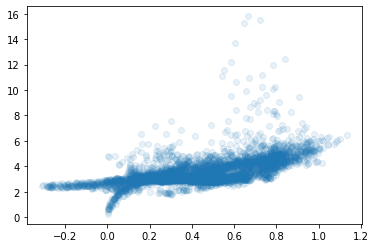

In [229]:
plt.scatter(dDelta_s, -dDsnowmean_dTs_px, alpha = 0.1)
# plt.yscale('log')

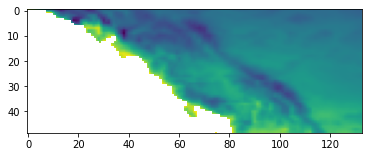

In [161]:
plt.imshow(fw.reshape(Nlat,Nlon))

In [173]:
plt.scatter(zmedian, T_px)

NameError: ignored

In [174]:
P_ratio_mask = np.copy(P_ratio)
P_ratio_mask[mask] = np.nan
sigma_ratio_mask = np.copy(sigma_ratio)
sigma_ratio_mask[mask] = np.nan
Dsnow_mask = np.copy(Dsnow)
Dsnow_mask[mask] = np.nan

# plt.scatter(Dsnow_mask, sigma_ratio_mask, c = dDsnow_dT0_px, alpha = 0.1)
# plt.scatter(-np.log(-dDsnow_dT0_px), sigma_ratio, alpha = 0.1)
plt.scatter(Dsnow, P_persist, c = zmedian, alpha = 0.1)
# plt.scatter(P_transition, P_persist, c = dDsnow_dT0_px, alpha = 0.2)
plt.colorbar()

NameError: ignored

(-100.0, 18.88186179302381)

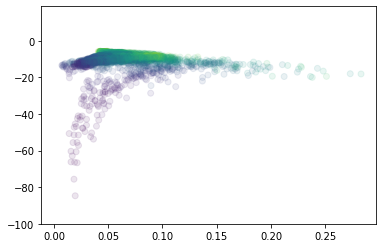

In [ ]:
plt.scatter(P_persist, dDsnow_dT0_px, c = zmedian, alpha = 0.1)
plt.ylim(bottom = -100)

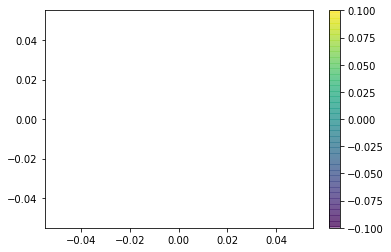

In [ ]:
# plt.scatter(Dsnow, dDsnow_dT0_px, c = P_ratio, alpha = 0.1)
# plt.scatter(Dsnow[mask], dDsnow_dT0_px[mask], c = labels, alpha = 0.5)
plt.scatter(Dsnow[mask], dDsnow_dT0_px[mask], c = T_px[mask], alpha = 0.5)
plt.colorbar()

In [ ]:
type(1.), np.isfinite(np.nan)

(float, False)

In [ ]:
mask = np.squeeze(np.argwhere(np.isfinite(dDsnow_dT0_px))) #not nan

cluster_input = np.zeros((len(mask), 4))
cluster_input[:,0] = Dsnow[mask]
cluster_input[:,1] = dDsnow_dT0_px[mask]
cluster_input[:,2] = P_ratio[mask]
cluster_input[:,3] = T_px[mask] #P_transition[mask]

cluster_input -= np.mean(cluster_input, axis = 0)
cluster_input /= np.std(cluster_input, axis = 0)

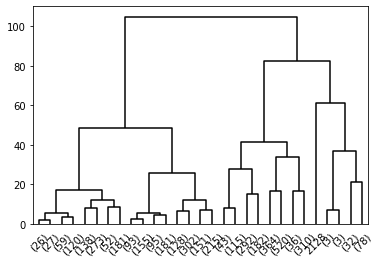

In [ ]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(cluster_input)

# plot the top levels of the dendrogram
d = plot_dendrogram(model, truncate_mode='level', p=4, color_threshold = 0, above_threshold_color = 'k')

In [ ]:
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(cluster_input)

labels = clustering.labels_

labels_nans = np.nan*np.zeros(Npx)
labels_nans[mask] = labels

#calculate average of each cluster
cluster_patterns = np.empty((n_clusters, np.shape(cluster_input)[1]))
for cluster in range(n_clusters):
  cluster_inds = np.argwhere(labels == cluster)
  cluster_patterns[cluster,:] = np.mean(cluster_input[cluster_inds.reshape(-1,1),:], axis = 0)

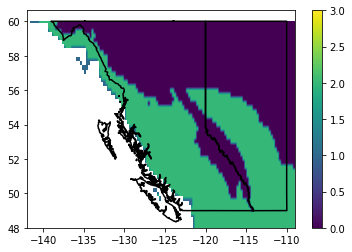

In [ ]:
fig, ax = plt.subplots()

im = ax.imshow(labels_nans.reshape(Nlat, Nlon), aspect = 'auto', extent = extentERA)
plot_prov_ax(['AB', 'BC'], ax)
plt.colorbar(im)

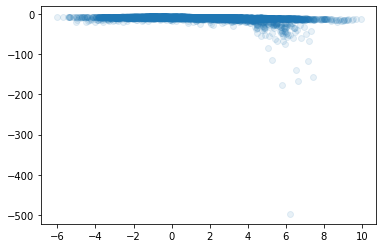

In [ ]:
plt.scatter(T0_px, dDsnow_dT0_px, alpha = 0.1)

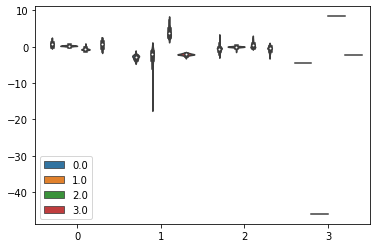

In [ ]:
xx = np.tile(labels, reps = 4)
yy = cluster_input.flatten()
yy = np.hstack([
                 cluster_input[:,0],
                 cluster_input[:,1], 
                 cluster_input[:,2],
                 cluster_input[:,3]
])
hue = np.hstack([
                 0*np.ones(len(labels)),
                 1*np.ones(len(labels)), 
                 2*np.ones(len(labels)),
                 3*np.ones(len(labels))
])

# sns.boxplot(x = labels, y = cluster_input[:,2])
# sns.boxplot(x = xx, y = yy, hue = hue)
sns.violinplot(x = xx, y = yy, hue = hue)

In [ ]:
np.shape(xx)

(16700,)

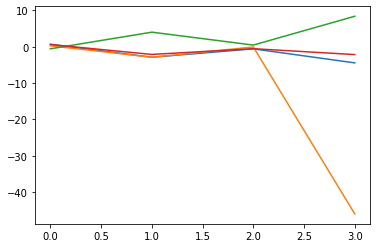

In [ ]:
plt.plot(cluster_patterns)
plt.show()

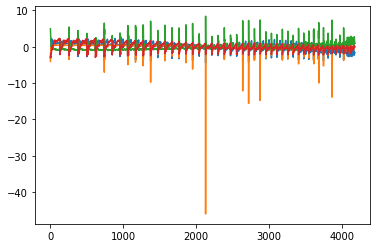

In [ ]:
plt.plot(cluster_input)
plt.show()

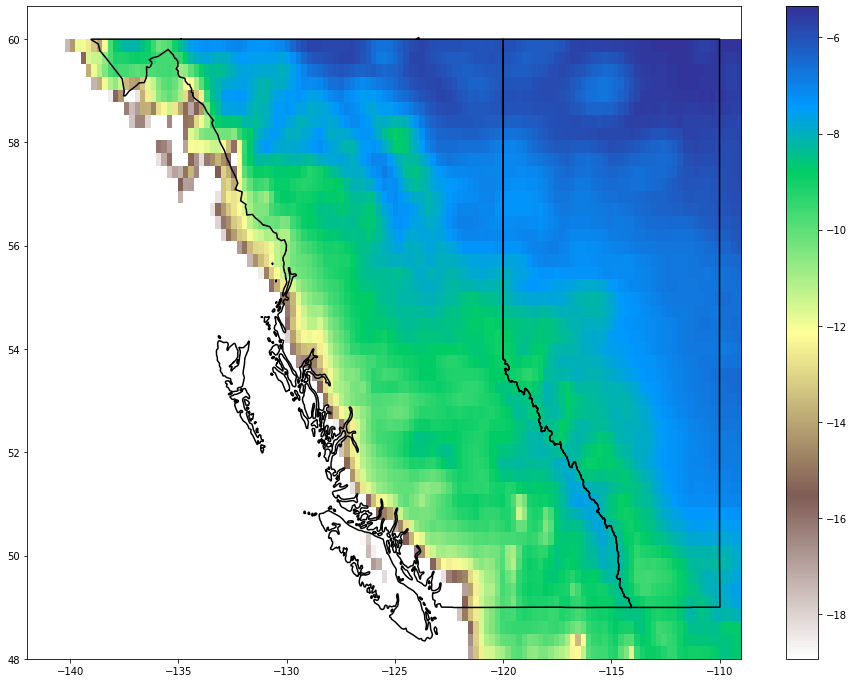

In [ ]:
# dDsnow_dT0_px[dDsnow_dT0_px<-20] = np.nan

fig, ax = plt.subplots(figsize = (16,12))

var = np.abs(dDsnowmean_dTw_px) / np.abs(dDsnowmean_dT0_px)
var = dDsnowmean_dT0_px

vmin = np.sort(var)[150]
cmap = 'terrain_r'
# cmap = 'RdBu'
# cmap = 'gnuplot'
# cmap = 'Reds_r'
im = ax.imshow(var.reshape(Nlat, Nlon), vmin = vmin, aspect = 'auto', extent = extentERA, cmap = cmap)
# im = ax.contourf(dDsnow_dT0_px.reshape(Nlat, Nlon), extent = [np.min(eraLon),np.max(eraLon),np.max(eraLat),np.min(eraLat)], cmap = cmap, vmin = -20)
plot_prov_ax(prov = ['AB', 'BC'], ax = ax)
plt.colorbar(im)

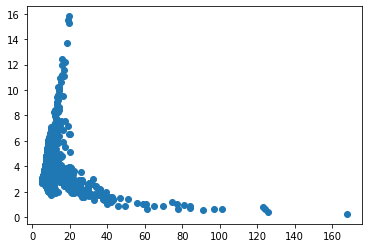

In [ ]:
plt.scatter(-dDsnowmean_dT0_px, -dDsnowmean_dTs_px)


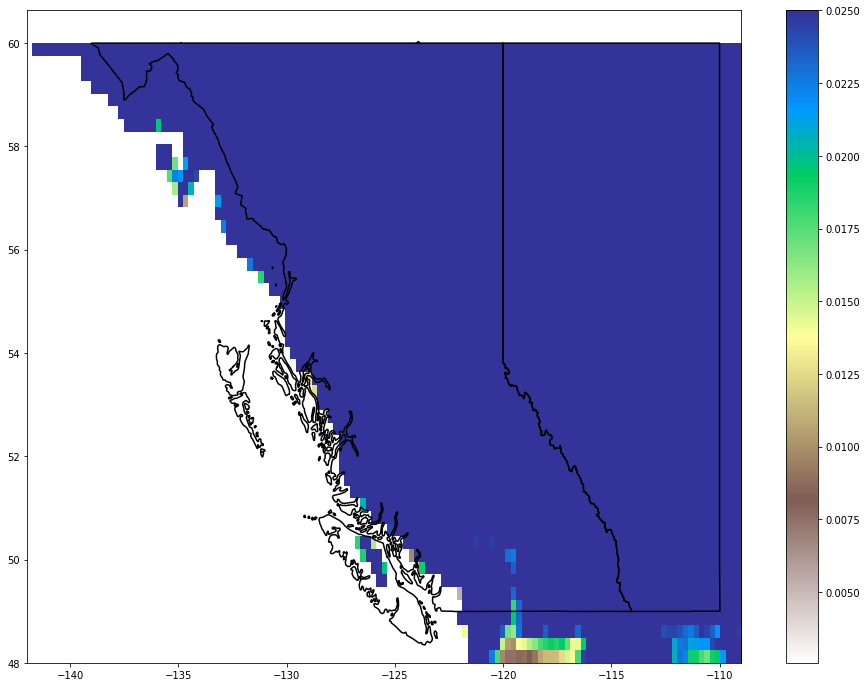

In [ ]:

fig, ax = plt.subplots(figsize = (16,12))

vmin = np.sort(dDsnow_dT0_px)[200]
cmap = 'terrain_r'
# cmap = 'RdBu'
# cmap = 'gnuplot'
# cmap = 'Reds_r'
im = ax.imshow(P_persist.reshape(Nlat, Nlon), aspect = 'auto', extent = extentERA, cmap = cmap, vmax = 0.025)
# im = ax.contourf(dDsnow_dT0_px.reshape(Nlat, Nlon), extent = [np.min(eraLon),np.max(eraLon),np.max(eraLat),np.min(eraLat)], cmap = cmap, vmin = -20)
plot_prov_ax(prov = ['AB', 'BC'], ax = ax)
plt.colorbar(im)

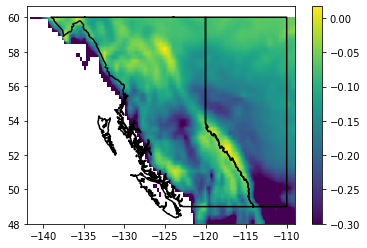

In [ ]:
dd = dtmeanm_dT0_px - dtpm_dT0_px #more positive = larger effect of variability on melting sensitivity
ddd = dd / dtmeanm_dT0_px

fig, ax = plt.subplots()
im = ax.imshow(ddd.reshape(Nlat,Nlon), aspect = 'auto', extent = extentERA, vmin = -0.3)#, vmax = 2)
plot_prov_ax(prov = ['AB', 'BC'], ax = ax)
plt.colorbar(im)

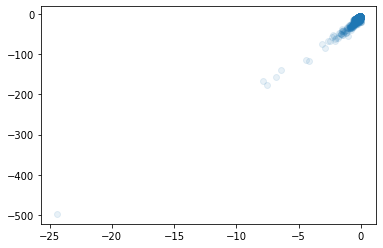

In [ ]:
plt.scatter(ddd, dDsnow_dT0_px, alpha = 0.1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


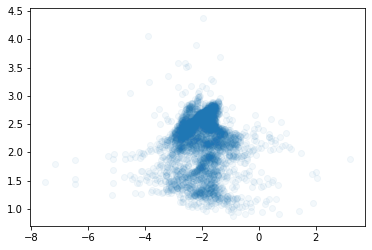

In [ ]:
plt.scatter(np.log(-ddd), sigma_ratio, alpha = 0.05)
# plt.xlim(left = -5)

In [ ]:
dd

array([        nan, 13.8392733 ,  9.04312088, ...,  1.44496433,
        1.53227937,  1.51415299])

(-50.0, 1.0)

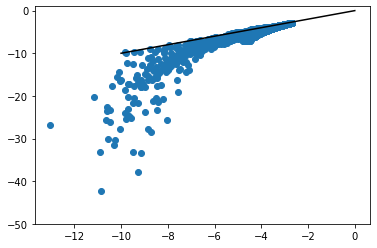

In [ ]:
plt.scatter(dtmeanm_dT0_px, dtpm_dT0_px)
plt.plot([-10,0],[-10,0], 'k')
plt.ylim((-50,1))

In [ ]:
TTs = np.linspace(0,3,100)

TT = 5
T1 = 40
T2 = T1-TT
T3 = T1+TT
dTp = 15
dTm = -15


w = 2*np.pi / 365
phi = 0

t = np.arange(365)

T0 = 3
Tmean = T0 - T1*np.sin(w*t-phi)
Tp = T0 + dTp - T2*np.sin(w*t-phi)
Tm = T0 + dTm - T3*np.sin(w*t-phi)

T0 = np.arange(-5,20, 0.1)
b1 = np.sqrt(1 - ((T0+dTp)/T2)**2)
b2 = np.sqrt(1 - ((T0+dTm)/T3)**2)

dDelta_dT0 = (1/(w*T1)) * (1/b1 - 1/b2)

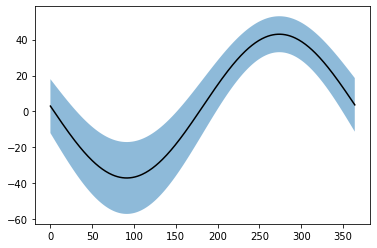

In [ ]:
fig, ax = plt.subplots()

ax.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
ax.plot((Tp+Tm)/2, 'k')

Text(0, 0.5, '$\\partial \\Delta / \\partial T0$')

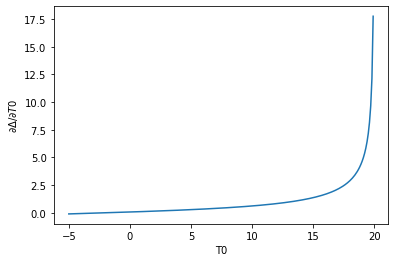

In [ ]:
plt.plot(T0, dDelta_dT0)
plt.xlabel('T0')
plt.ylabel('$\partial \Delta / \partial T0$')

In [ ]:
TTs = np.linspace(0,2,10)
dDelta_dT0 = np.zeros((len(TTs), len(T0)))

for kk, TT in enumerate(TTs):

  T1 = 15
  T2 = T1-TT
  T3 = T1+TT
  dTp = 5
  dTm = -5

  w = 2*np.pi / 365
  phi = 0

  t = np.arange(365)

  T0 = 0
  Tmean = T0 - T1*np.sin(w*t-phi)
  Tp = T0 + dTp - T2*np.sin(w*t-phi)
  Tm = T0 + dTm - T3*np.sin(w*t-phi)

  T0 = np.arange(-3,3, 0.1)
  b1 = np.sqrt(1 - ((T0+dTp)/T2)**2)
  b2 = np.sqrt(1 - ((T0+dTm)/T3)**2)

  dDelta_dT0[kk,:] = (1/(w*T1)) * (1/b1 - 1/b2)

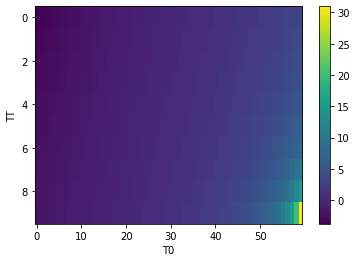

In [ ]:
plt.imshow(dDelta_dT0, aspect = 'auto')
plt.ylabel('TT')
plt.xlabel('T0')
plt.colorbar()

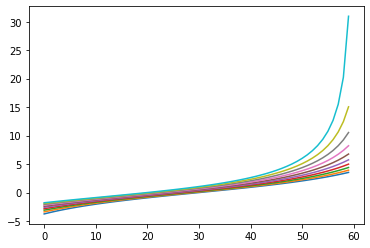

In [ ]:
plt.plot(dDelta_dT0.T)
plt.show()

# Temperature change partitioning

In [67]:
#"Edmonton-like"
T = 14
T0 = 3
sigma_s = 11
sigma_w = 9

# #"Lethbridge-like"
# T = 12
# T0 = 6
# sigma_s = 16
# sigma_w = 11

#"Lloydminster-like"
T = 15
T0 = 2.5
sigma_s = 10
sigma_w = 8

omega = 2*np.pi / 365
phi = 0

A =  0.25 * ( sigma_s + sigma_w )
B =  0.25 * ( sigma_s - sigma_w ) + T
C = -0.25 * ( sigma_s + sigma_w )
D =  0.25 * (-sigma_s + sigma_w ) + T

t = np.arange(365)

# delta_T0 = 1
Ndelta_T0 = 2000
Ndelta_partition = 10


Tmean = np.zeros((Ndelta_T0, Ndelta_partition, 365))
tmeanf = np.zeros((Ndelta_T0, Ndelta_partition))
tmeanm = np.zeros((Ndelta_T0, Ndelta_partition))

dtmeanf_dT0 = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanm_dT0 = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanf_dTw = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanm_dTw = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanf_dTs = np.zeros((Ndelta_T0, Ndelta_partition))
dtmeanm_dTs = np.zeros((Ndelta_T0, Ndelta_partition))

Dsnow = np.zeros((Ndelta_T0, Ndelta_partition))
dDsnow_dT0 = np.zeros((Ndelta_T0, Ndelta_partition))
dDsnow_dTw = np.zeros((Ndelta_T0, Ndelta_partition))
dDsnow_dTs = np.zeros((Ndelta_T0, Ndelta_partition))

delta_T0 = np.linspace(0,5,Ndelta_T0)
delta_Tw = np.zeros((Ndelta_T0, Ndelta_partition))
delta_Ts = np.zeros((Ndelta_T0, Ndelta_partition))
deltaTw_deltaT0 = np.zeros((Ndelta_T0, Ndelta_partition))
# T0 = T0 + delta_T0

for jj, delta_T0jj in enumerate(delta_T0):
    
  T0jj = T0 + delta_T0jj

  dTw = delta_T0jj / Ndelta_partition
  delta_Tw[jj,:] = np.linspace(0,2*delta_T0jj,Ndelta_partition)
  delta_Ts[jj,:] = 2*delta_T0jj - delta_Tw[jj,:]
  deltaTw_deltaT0[jj,:] = delta_Tw[jj,:] / delta_T0jj

  for kk, delta_Twkk in enumerate(delta_Tw[jj,:]):

    Ts = T0jj + T + delta_Ts[jj,kk]
    Tw = T0jj - T + delta_Tw[jj,kk]

    T0kk = (Ts + Tw) / 2
    Tkk = Ts - Tw
    phi = 0#np.pi / 2


    Tmean[jj,kk,:] = T0kk - Tkk*np.sin(omega*t - phi)
    # Tp = T0 + A - B*np.sin(omega*t - phi)
    # Tm = T0 + C - D*np.sin(omega*t - phi)

    tmeanf[jj,kk] = (1/omega) * (phi + np.arcsin(T0kk/Tkk))
    tmeanm[jj,kk] = (1/omega) * (np.pi + phi - np.arcsin(T0kk/Tkk))

    # tpf = (1/omega) * (phi + np.arcsin((T0+A)/B))
    # tpm = (1/omega) * (np.pi + phi - np.arcsin((T0+A)/B))

    # tmf = (1/omega) * (phi + np.arcsin((T0+C)/D))
    # tmm = (1/omega) * (np.pi + phi - np.arcsin((T0+C)/D))

    Dsnow[jj,kk] = tmeanm[jj,kk] - tmeanf[jj,kk]

    dtmeanf_dT0[jj,kk] =  (1 / (omega*Tkk)) * np.sqrt(1 - (T0kk/Tkk)**2)**(-1)
    dtmeanm_dT0[jj,kk] = -(1 / (omega*Tkk)) * np.sqrt(1 - (T0kk/Tkk)**2)**(-1)

    # dtpf_dT0 =  (1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)
    # dtpm_dT0 = -(1 / (omega*B)) * np.sqrt(1 - ((T0+A)/B)**2)**(-1)

    # dtmf_dT0 =  (1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)
    # dtmm_dT0 = -(1 / (omega*D)) * np.sqrt(1 - ((T0+C)/D)**2)**(-1)

    dDsnow_dT0[jj,kk] = dtmeanm_dT0[jj,kk] - dtmeanf_dT0[jj,kk]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


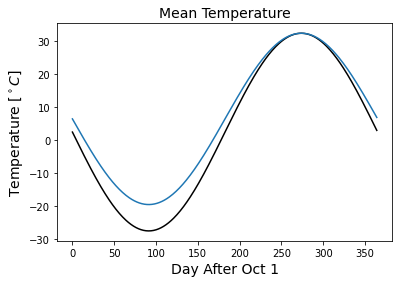

In [85]:
saveIt = 0

fontsize = 14

fig, ax = plt.subplots()
ax.plot(Tmean[0,0,:],'k')
# ax.plot(Tmean[1200,0,:])
# ax.plot(Tmean[600,0,:])
ax.plot(Tmean[800,-1,:])

ax.set_xlabel('Day After Oct 1', fontsize = fs)
ax.set_ylabel('Temperature [$^\circ C$]', fontsize = fs)
ax.set_title('Mean Temperature', fontsize = fs)

if saveIt:
  # plt.savefig('imbalanced_warming.png', bbox_inches = 'tight', dpi = 300)
  plt.savefig('winter_warming.png', bbox_inches = 'tight', dpi = 300)
  # plt.savefig('summer_warming.png', bbox_inches = 'tight', dpi = 300)

plt.show()

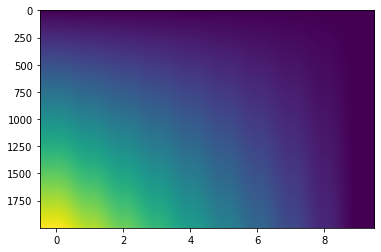

In [128]:
plt.imshow(delta_Ts, aspect = 'auto')

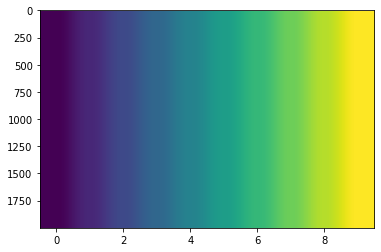

In [56]:
plt.imshow(deltaTw_deltaT0, aspect = 'auto')

Text(0, 0.5, '$\\Delta T_w$')

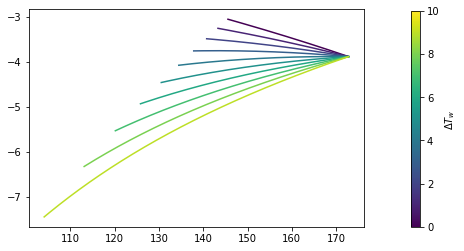

In [57]:
cmap = 'viridis'
cmap = cm.get_cmap(cmap)
# norm = matplotlib.colors.Normalize(vmin = np.min(deltaTw_deltaT0), vmax = np.max(deltaTw_deltaT0))
norm = matplotlib.colors.Normalize(vmin = 0, vmax = Ndelta_partition)
colors = cmap(norm(range(Ndelta_partition)))

fig, ax = plt.subplots()
for kk in range(Ndelta_partition):
  # color = cmap(norm(deltaTw_deltaT0[kk]))
  # color = cmap(norm(delta_Tw[kk]))
  # ax.plot(delta_T0, dDsnow_dT0[:,kk], color = colors[kk,:])
  ax.plot(Dsnow[:,kk], dDsnow_dT0[:,kk], color = colors[kk,:])

#add colorbar
width = 0.02
height = 0.75
dh = (1-height)/2
dw = (1-width)/2
ax_cb = fig.add_axes([1.01,dh,width,height])
cb = matplotlib.colorbar.ColorbarBase(ax = ax_cb, cmap = cmap, norm = norm)
ax_cb.set_ylabel('$\Delta T_w$')


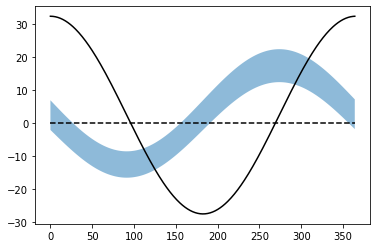

In [ ]:
plt.fill_between(x = t, y1 = Tp, y2 = Tm, alpha = 0.5)
plt.plot(t, Tmean[0,0], 'k')

plt.plot(t, np.zeros(len(t)), 'k--')

# plt.scatter(tmeanf, 0)